In [9]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [8]:
%cd /home/paperspace/fastai/courses/ml1/

/home/paperspace/fastai/courses/ml1


In [11]:
%ls

bulldozer_dl.ipynb            images/
bulldozer_linreg.ipynb        lesson1-rf.ipynb
data/                         lesson2-rf_interpretation.ipynb
Ethics in Data Science.ipynb  lesson3-rf_foundations.ipynb
excel/                        lesson4-mnist_sgd.ipynb
fastai@                       lesson5-nlp.ipynb
fraud_detection.ipynb         ppt/


In [5]:
%ls data

bulldozers/  fraud-detection/


In [6]:
%ls data/fraud-detection/

models/  tmp/  train.csv  train_sample.csv


In [30]:
PATH = "/home/paperspace/data/adfraud/"

In [31]:
!ls {PATH}

train.csv


### Get the data from Kaggle 

In [21]:
ROOT = '/home/paperspace/'

In [22]:
NTBK = ROOT+'fastai/courses/dl1/'

In [23]:
%cd {NTBK}data

/home/paperspace/data


In [24]:
%ls

dogbreeds/  dogscats/  planet/


In [25]:
CREDS = []
with open(f'{NTBK}CRED.txt') as f:
    for line in f:
        CREDS.append(line.strip('\n').split(':')[1])

In [27]:
from kaggle_data.downloader import KaggleDataDownloader

destination_path = f"{ROOT}data/adfraud/"

downloader = KaggleDataDownloader(CREDS[0], CREDS[1], "talkingdata-adtracking-fraud-detection")
output_path = downloader.download_dataset("train.csv.zip", destination_path)
downloader.decompress(output_path, destination_path)

train.csv.zip N/A% |                                 | ETA:  --:--:--   0.0 s/B

downloading https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/download/train.csv.zip to /home/paperspace/data/adfraud/train.csv.zip



train.csv.zip 100% |################################| Time: 0:00:25  48.2 MiB/s


Extracting /home/paperspace/data/adfraud/train.csv.zip to /home/paperspace/data/adfraud/ ...
Extraction finished


In [9]:
df_raw = pd.read_csv(f'{PATH}train_sample.csv', low_memory=False)

In [9]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)

In [11]:
display_all(df_raw.tail().transpose())

,99995,99996,99997,99998,99999
ip,124883,85150,18839,114276,119349
app,11,9,3,15,14
device,1,1,1,1,1
os,19,13,13,12,15
channel,122,244,19,245,401
click_time,2017-11-09 13:25:41,2017-11-07 11:25:43,2017-11-08 11:38:42,2017-11-08 17:55:21,2017-11-07 14:32:27
attributed_time,NaN,NaN,NaN,NaN,NaN
is_attributed,0,0,0,0,0


In [12]:
df_raw.drop(columns=['attributed_time'],inplace=True)

In [13]:
display_all(df_raw.tail().transpose())

,99995,99996,99997,99998,99999
ip,124883,85150,18839,114276,119349
app,11,9,3,15,14
device,1,1,1,1,1
os,19,13,13,12,15
channel,122,244,19,245,401
click_time,2017-11-09 13:25:41,2017-11-07 11:25:43,2017-11-08 11:38:42,2017-11-08 17:55:21,2017-11-07 14:32:27
is_attributed,0,0,0,0,0


In [14]:
display_all(df_raw.describe(include='all').transpose())

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ip,100000,NaN,NaN,NaN,91255.9,69835.6,9,40552,79827,118252,364757
app,100000,NaN,NaN,NaN,12.0479,14.9415,1,3,12,15,551
device,100000,NaN,NaN,NaN,21.7712,259.668,0,1,1,1,3867
os,100000,NaN,NaN,NaN,22.8183,55.9431,0,13,18,19,866
channel,100000,NaN,NaN,NaN,268.832,129.724,3,145,258,379,498
click_time,100000,80350,2017-11-08 12:01:02,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_attributed,100000,NaN,NaN,NaN,0.00227,0.0475906,0,0,0,0,1


In [31]:
df_raw.head(10)

,ip,app,device,os,channel,click_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,0
1,105560,25,1,17,259,2017-11-07 13:40:27,0
2,101424,12,1,19,212,2017-11-07 18:05:24,0
3,94584,13,1,13,477,2017-11-07 04:58:08,0
4,68413,12,1,1,178,2017-11-09 09:00:09,0
5,93663,3,1,17,115,2017-11-09 01:22:13,0
6,17059,1,1,17,135,2017-11-09 01:17:58,0
7,121505,9,1,25,442,2017-11-07 10:01:53,0
8,192967,2,2,22,364,2017-11-08 09:35:17,0
9,143636,3,1,19,135,2017-11-08 12:35:26,0


In [15]:
df_raw.sort_values(by='click_time', inplace=True)
df_raw.head()

,ip,app,device,os,channel,click_time,is_attributed
54955,48646,12,1,19,178,2017-11-06 16:00:00,0
28314,93836,12,1,30,328,2017-11-06 16:00:09,0
31830,5314,8,1,13,145,2017-11-06 16:00:09,0
99357,73954,23,1,19,153,2017-11-06 16:00:11,0
83228,91574,3,1,17,135,2017-11-06 16:00:11,0


In [16]:
df_raw.reset_index(inplace=True, drop=True) #reset index since we reordered by date

In [17]:
add_datepart(df_raw, 'click_time')

In [18]:
display_all(df_raw.tail().transpose())

,99995,99996,99997,99998,99999
ip,85592,91779,81374,11911,44018
app,12,18,14,1,13
device,1,1,1,1,1
os,13,41,25,22,19
channel,145,379,118,115,477
is_attributed,0,0,0,0,0
click_timeYear,2017,2017,2017,2017,2017
click_timeMonth,11,11,11,11,11
click_timeWeek,45,45,45,45,45
click_timeDay,9,9,9,9,9


In [19]:
print(df_raw.dtypes)

ip                            int64
app                           int64
device                        int64
os                            int64
channel                       int64
is_attributed                 int64
click_timeYear                int64
click_timeMonth               int64
click_timeWeek                int64
click_timeDay                 int64
click_timeDayofweek           int64
click_timeDayofyear           int64
click_timeIs_month_end         bool
click_timeIs_month_start       bool
click_timeIs_quarter_end       bool
click_timeIs_quarter_start     bool
click_timeIs_year_end          bool
click_timeIs_year_start        bool
click_timeElapsed             int64
dtype: object


In [20]:
%pwd

'/home/zlandes/fastai/courses/ml1'

In [21]:
!ls

bulldozer_dl.ipynb		 lesson4-mnist_sgd.ipynb
bulldozer_linreg.ipynb		 lesson5-nlp.ipynb
data				 ppt
Ethics in Data Science.ipynb	 tmp
excel				 tmp_fraud
fastai				 tmp_fraud_detection.ipynb
images				 tmp-lesson1-rf.ipynb
lesson1-rf.ipynb		 tmp-lesson2-rf_interpretation.ipynb
lesson2-rf_interpretation.ipynb  tmp-zml-lesson2.ipynb
lesson3-rf_foundations.ipynb


In [60]:
os.makedirs('tmp_fraud', exist_ok=True)
df_raw.to_feather('tmp_fraud/fraud-raw')

## Reload our Model 

In [8]:
df_raw = pd.read_feather('tmp_fraud/fraud-raw')

In [9]:
df_raw.shape

(100000, 19)

In [10]:
df, y, nas = proc_df(df_raw, 'is_attributed')

In [11]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 20000
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((80000, 18), (80000,), (20000, 18))

In [12]:
def print_score(m):
    res = [metrics.roc_auc_score(y_train, m.predict(X_train)), metrics.roc_auc_score(y_valid, m.predict(X_valid)),
          m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [69]:
m = RandomForestClassifier(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 706 ms, sys: 0 ns, total: 706 ms
Wall time: 261 ms
[0.9038461538461539, 0.5554803864250119, 0.9995625, 0.99785]


In [70]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=40)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 2.52 s, sys: 7.92 ms, total: 2.53 s
Wall time: 476 ms
[0.989010989010989, 0.5333333333333333, 0.99995, 0.9979]


In [72]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=40, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 2.66 s, sys: 0 ns, total: 2.66 s
Wall time: 666 ms
[0.989010989010989, 0.5444444444444444, 0.99995, 0.99795, 0.9978875]


We are overfitting badly

In [73]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=40, min_samples_leaf=3, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 2.73 s, sys: 2.13 ms, total: 2.73 s
Wall time: 639 ms
[0.5879120879120879, 0.5, 0.998125, 0.99775, 0.997725]


In [74]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=40, max_features = 0.5, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 4.81 s, sys: 0 ns, total: 4.81 s
Wall time: 1 s
[0.9917582417582418, 0.6110359419805674, 0.9999625, 0.9981, 0.9978125]


In [75]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=40, max_features = 'sqrt', oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 2.73 s, sys: 3.94 ms, total: 2.73 s
Wall time: 648 ms
[0.9945054945054945, 0.5110860547342632, 0.999975, 0.99775, 0.9976875]


In [33]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=40, max_features = 0.5, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 4.74 s, sys: 20.8 ms, total: 4.76 s
Wall time: 1.02 s
[0.9972527472527473, 0.6775773267629945, 0.9999875, 0.99815, 0.9979]


## Feature Importance

In [34]:
fi = rf_feat_importance(m, df); fi

,cols,imp
0,ip,0.280969
17,click_timeElapsed,0.198618
4,channel,0.171637
1,app,0.132728
3,os,0.116571
2,device,0.058369
8,click_timeDay,0.015838
9,click_timeDayofweek,0.012685
10,click_timeDayofyear,0.012585
5,click_timeYear,0.000000


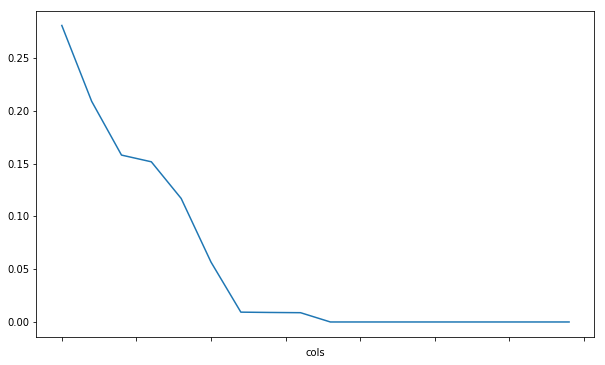

In [78]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [81]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

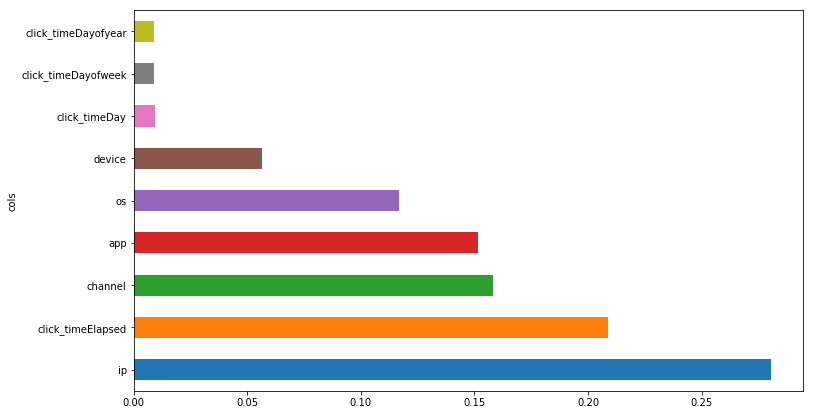

In [83]:
plot_fi(fi[:9]);

In [84]:
to_keep = fi[fi.imp>0].cols;
to_keep

0                      ip
17      click_timeElapsed
4                 channel
1                     app
3                      os
2                  device
8           click_timeDay
9     click_timeDayofweek
10    click_timeDayofyear
Name: cols, dtype: object

In [85]:
len(to_keep)

9

In [87]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [88]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=40, max_features = 0.5, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9835164835164836, 0.6109858292268716, 0.999925, 0.998, 0.997875]


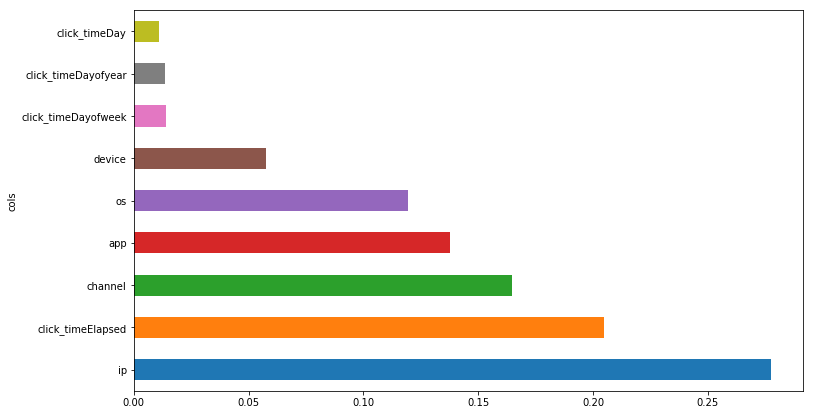

In [89]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi)

Clearly for this tiny data set that only covers a few days, day of year and day of week are perfectly correlated

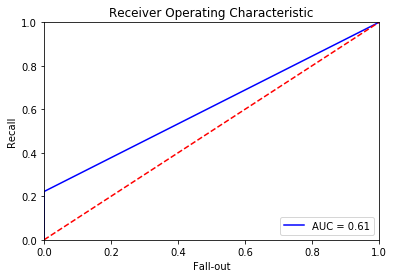

In [98]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, recall, thresholds = roc_curve(y_valid, m.predict(X_valid))
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

## Predicting past avg by IP: A Model

In [55]:
a = df_raw[['ip', 'is_attributed']].groupby('ip', as_index=False).mean()

In [58]:
b = a[a.is_attributed>0.0]

In [59]:
b.shape

(223, 2)

### To Do:
Left join (merge) the validation set with a, on 'ip', and if there is no match (i.e. null value in the is_attributed field), assign the value = fraction of 1s in training set, else use the probability in a. The is_attributed column is then the set of predictions for the validation set. 

In [43]:
X_valid.head()

,ip,app,device,os,channel,click_timeYear,click_timeMonth,click_timeWeek,click_timeDay,click_timeDayofweek,click_timeDayofyear,click_timeIs_month_end,click_timeIs_month_start,click_timeIs_quarter_end,click_timeIs_quarter_start,click_timeIs_year_end,click_timeIs_year_start,click_timeElapsed
80000,170739,3,1,31,280,2017,11,45,9,3,313,False,False,False,False,False,False,1510202930
80001,178261,15,1,11,315,2017,11,45,9,3,313,False,False,False,False,False,False,1510202931
80002,44004,3,1,8,280,2017,11,45,9,3,313,False,False,False,False,False,False,1510202934
80003,96037,9,1,25,466,2017,11,45,9,3,313,False,False,False,False,False,False,1510202936
80004,71686,3,1,13,135,2017,11,45,9,3,313,False,False,False,False,False,False,1510202937


In [76]:
ip_raw = X_valid.merge(b, how='left', on=['ip'])

In [63]:
ip_raw.head()

,ip,app,device,os,channel,click_timeYear,click_timeMonth,click_timeWeek,click_timeDay,click_timeDayofweek,click_timeDayofyear,click_timeIs_month_end,click_timeIs_month_start,click_timeIs_quarter_end,click_timeIs_quarter_start,click_timeIs_year_end,click_timeIs_year_start,click_timeElapsed,is_attributed
0,170739,3,1,31,280,2017,11,45,9,3,313,False,False,False,False,False,False,1510202930,NaN
1,178261,15,1,11,315,2017,11,45,9,3,313,False,False,False,False,False,False,1510202931,NaN
2,44004,3,1,8,280,2017,11,45,9,3,313,False,False,False,False,False,False,1510202934,NaN
3,96037,9,1,25,466,2017,11,45,9,3,313,False,False,False,False,False,False,1510202936,NaN
4,71686,3,1,13,135,2017,11,45,9,3,313,False,False,False,False,False,False,1510202937,NaN


In [74]:
len(y_train[np.where(y_train>0)])

182

In [77]:
avg_prob = 182/80000
ip = ip_raw.fillna(value=avg_prob)
ip.head()

,ip,app,device,os,channel,click_timeYear,click_timeMonth,click_timeWeek,click_timeDay,click_timeDayofweek,click_timeDayofyear,click_timeIs_month_end,click_timeIs_month_start,click_timeIs_quarter_end,click_timeIs_quarter_start,click_timeIs_year_end,click_timeIs_year_start,click_timeElapsed,is_attributed
0,170739,3,1,31,280,2017,11,45,9,3,313,False,False,False,False,False,False,1510202930,0.002275
1,178261,15,1,11,315,2017,11,45,9,3,313,False,False,False,False,False,False,1510202931,0.002275
2,44004,3,1,8,280,2017,11,45,9,3,313,False,False,False,False,False,False,1510202934,0.002275
3,96037,9,1,25,466,2017,11,45,9,3,313,False,False,False,False,False,False,1510202936,0.002275
4,71686,3,1,13,135,2017,11,45,9,3,313,False,False,False,False,False,False,1510202937,0.002275


In [78]:
preds = ip.is_attributed
preds.shape

(20000,)

In [79]:
metrics.roc_auc_score(y_valid, preds)

0.9993524318605752

In [81]:
avg_preds = np.full(shape=(20000,), fill_value=avg_prob)

In [82]:
metrics.roc_auc_score(y_valid, avg_preds)

0.5

## Full training set 

### Load the data 

In [84]:
df_raw = pd.read_csv(f'{PATH}train.csv', usecols=['ip', 'click_time', 'is_attributed'])

In [85]:
df_raw.sort_values(by='click_time', inplace=True)
df_raw.reset_index(inplace=True, drop=True)

In [86]:
df_raw.head()

,ip,click_time,is_attributed
0,83230,2017-11-06 14:32:21,0
1,17357,2017-11-06 14:33:34,0
2,35810,2017-11-06 14:34:12,0
3,45745,2017-11-06 14:34:52,0
4,161007,2017-11-06 14:35:08,0


In [87]:
df_raw.tail()

,ip,click_time,is_attributed
184903885,85836,2017-11-09 16:00:00,0
184903886,320126,2017-11-09 16:00:00,0
184903887,25614,2017-11-09 16:00:00,0
184903888,92190,2017-11-09 16:00:00,0
184903889,106485,2017-11-09 16:00:00,0


In [88]:
df_raw.drop(['click_time'], axis=1, inplace=True)

In [89]:
df_raw.shape

(184903890, 2)

In [94]:
df, y, nas = proc_df(df_raw, 'is_attributed')

In [96]:
n_valid = int(len(df_raw)*.5)
n_trn = len(df_raw)-n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((92451945, 1), (92451945,), (92451945, 1))

### Generate the model 

In [97]:
a = df_raw[['ip', 'is_attributed']].groupby('ip', as_index=False).mean()

In [98]:
b = a[a.is_attributed>0.0]

In [99]:
b.shape

(245038, 2)

In [100]:
X_valid.head()

,ip
92451945,153697
92451946,14044
92451947,124219
92451948,276554
92451949,103391


In [101]:
ip_raw = X_valid.merge(b, how='left', on=['ip'])

In [102]:
ip_raw.head()

,ip,is_attributed
0,153697,0.001341
1,14044,0.000883
2,124219,0.000915
3,276554,0.003521
4,103391,0.001536


In [105]:
num_ones= len(y_train[np.where(y_train>0)])

In [106]:
avg_prob = num_ones/80000
ip = ip_raw.fillna(value=avg_prob)
ip.head()

,ip,is_attributed
0,153697,0.001341
1,14044,0.000883
2,124219,0.000915
3,276554,0.003521
4,103391,0.001536


In [107]:
preds = ip.is_attributed
preds.shape

(92451945,)

In [108]:
metrics.roc_auc_score(y_valid, preds)

0.8087273330393331

## DL Model 

In [8]:
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

In [22]:
df_raw = pd.read_feather('tmp_fraud/fraud-raw')

In [23]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

app                           0.0
channel                       0.0
click_timeDay                 0.0
click_timeDayofweek           0.0
click_timeDayofyear           0.0
click_timeElapsed             0.0
click_timeIs_month_end        0.0
click_timeIs_month_start      0.0
click_timeIs_quarter_end      0.0
click_timeIs_quarter_start    0.0
click_timeIs_year_end         0.0
click_timeIs_year_start       0.0
click_timeMonth               0.0
click_timeWeek                0.0
click_timeYear                0.0
device                        0.0
ip                            0.0
is_attributed                 0.0
os                            0.0
dtype: float64

In [24]:
df_raw.head(40)

,ip,app,device,os,channel,is_attributed,click_timeYear,click_timeMonth,click_timeWeek,click_timeDay,click_timeDayofweek,click_timeDayofyear,click_timeIs_month_end,click_timeIs_month_start,click_timeIs_quarter_end,click_timeIs_quarter_start,click_timeIs_year_end,click_timeIs_year_start,click_timeElapsed
0,48646,12,1,19,178,0,2017,11,45,6,0,310,False,False,False,False,False,False,1509984000
1,93836,12,1,30,328,0,2017,11,45,6,0,310,False,False,False,False,False,False,1509984009
2,5314,8,1,13,145,0,2017,11,45,6,0,310,False,False,False,False,False,False,1509984009
3,73954,23,1,19,153,0,2017,11,45,6,0,310,False,False,False,False,False,False,1509984011
4,91574,3,1,17,135,0,2017,11,45,6,0,310,False,False,False,False,False,False,1509984011
5,25705,2,1,19,205,0,2017,11,45,6,0,310,False,False,False,False,False,False,1509984013
6,93057,15,1,19,130,0,2017,11,45,6,0,310,False,False,False,False,False,False,1509984019
7,87868,15,1,19,153,0,2017,11,45,6,0,310,False,False,False,False,False,False,1509984020
8,106524,12,1,28,178,0,2017,11,45,6,0,310,False,False,False,False,False,False,1509984020
9,1415,9,1,13,134,0,2017,11,45,6,0,310,False,False,False,False,False,False,1509984021


In [26]:
cat_vars = ['ip', 'app', 'channel', 'device', 'os', 'click_timeDayofweek', 'click_timeDay', 'click_timeDayofyear']

contin_vars = ['click_timeElapsed']

n = len(df_raw); n

100000

In [27]:
dep = 'is_attributed'
df_raw = df_raw[cat_vars+contin_vars+[dep]].copy()

In [29]:
for v in cat_vars: df_raw[v] = df_raw[v].astype('category').cat.as_ordered()

In [35]:
for v in contin_vars:
    df_raw[v] = df_raw[v].astype('float64')

In [62]:
df_raw[dep] = df_raw[dep].astype('float32')

In [63]:
df, y, nas, mapper = proc_df(df_raw, dep, do_scale=True)

In [64]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 20000
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((80000, 9), (80000,), (20000, 9))

In [43]:
val_idx = list(range(n_trn, len(df)))

In [76]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y, cat_flds=cat_vars, bs=128)

In [77]:
cat_sz = [(c, len(df_raw[c].cat.categories)+1) for c in cat_vars]

In [78]:
cat_sz

[('ip', 34858),
 ('app', 162),
 ('channel', 162),
 ('device', 101),
 ('os', 131),
 ('click_timeDayofweek', 5),
 ('click_timeDay', 5),
 ('click_timeDayofyear', 5)]

In [79]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [80]:
emb_szs

[(34858, 50),
 (162, 50),
 (162, 50),
 (101, 50),
 (131, 50),
 (5, 3),
 (5, 3),
 (5, 3)]

In [82]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=(0, 1))

In [67]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.002195   0.002225  



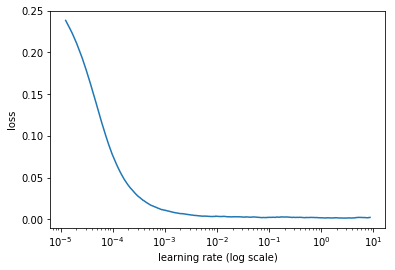

In [68]:
m.sched.plot()

In [69]:
lr = 1e-4

In [70]:
def my_auc(y_pred, targ):
    return metrics.roc_auc_score(targ, y_pred)

In [83]:
m.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.002437   0.002437  
    1      0.002245   0.002228                                  
    2      0.002413   0.002193                                  



[0.002192959]

In [84]:
m.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.002202   0.002058  
    1      0.00171    0.001936                                  
    2      0.001351   0.001823                                  



[0.0018230769]

In [85]:
preds = m.predict()

In [89]:
metrics.roc_auc_score(y_valid, preds)

0.9858648626075336

### Run DL on 10million of training set

In [32]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

In [33]:
df_raw = pd.read_csv(f'{PATH}train.csv', dtype=dtypes, usecols=['ip', 'app', 'click_time', 'is_attributed',\
                                                 'os', 'channel', 'device'], nrows=10000000)

In [34]:
df_raw.sort_values(by='click_time', inplace=True)
df_raw.head()

,ip,app,device,os,channel,click_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,0
1,17357,3,1,19,379,2017-11-06 14:33:34,0
2,35810,3,1,13,379,2017-11-06 14:34:12,0
3,45745,14,1,13,478,2017-11-06 14:34:52,0
4,161007,3,1,13,379,2017-11-06 14:35:08,0


In [35]:
df_raw.reset_index(inplace=True, drop=True) #reset index since we reordered by date

In [36]:
add_datepart(df_raw, 'click_time')

In [54]:
cat_vars = ['ip', 'app', 'channel', 'device', 'os', 'click_timeDayofweek', 'click_timeDay']

contin_vars = ['click_timeElapsed']

n = len(df_raw); n

10000000

In [55]:
dep = 'is_attributed'
df_raw = df_raw[cat_vars+contin_vars+[dep]].copy()

In [56]:
for v in cat_vars: df_raw[v] = df_raw[v].astype('category').cat.as_ordered()

In [57]:
for v in contin_vars:
    df_raw[v] = df_raw[v].astype('float64')

In [58]:
df_raw[dep] = df_raw[dep].astype('float32')

In [59]:
df, y, nas, mapper = proc_df(df_raw, dep, do_scale=True)

In [60]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 2000000
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((8000000, 8), (8000000,), (2000000, 8))

In [61]:
val_idx = list(range(n_trn, len(df)))

In [62]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y, cat_flds=cat_vars, bs=256)

In [63]:
cat_sz = [(c, len(df_raw[c].cat.categories)+1) for c in cat_vars]

In [64]:
cat_sz

[('ip', 68741),
 ('app', 333),
 ('channel', 171),
 ('device', 941),
 ('os', 293),
 ('click_timeDayofweek', 3),
 ('click_timeDay', 3)]

In [65]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [66]:
emb_szs

[(68741, 50), (333, 50), (171, 50), (941, 50), (293, 50), (3, 2), (3, 2)]

In [67]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=(0, 1))

In [68]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                      
    0      0.001936   0.001791  



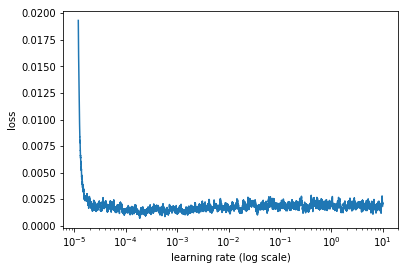

In [76]:
m.sched.plot(400)

In [79]:
lr = (1e-4)/4

In [80]:
m.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                       
    0      0.00136    0.001295  
    1      0.00148    0.001268                                       
    2      0.001348   0.001244                                       



[0.0012441417]

In [81]:
preds = m.predict()

In [82]:
metrics.roc_auc_score(y_valid, preds)

0.9297823622871474

In [83]:
preds[:10]

array([[0.00005],
       [0.00007],
       [0.00093],
       [0.00122],
       [0.00262],
       [0.     ],
       [0.00012],
       [0.00082],
       [0.00007],
       [0.00031]], dtype=float32)

In [84]:
m.save('fraud_10mil')

In [4]:
learn.load('fraud_10mil')

NameError: name 'learn' is not defined

### Let's try some oversampling (and probability calibration) methods 

In [106]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

In [162]:
df_raw = pd.read_csv(f'{PATH}train.csv', dtype=dtypes, usecols=['ip', 'app', 'click_time', 'is_attributed',\
                                                 'os', 'channel', 'device'], nrows=10000000)

going to randomly sample 20% of 10 million rows of the data to save memory

In [163]:
df_raw = df_raw.sample(frac=.2).copy().reset_index(drop=True)

In [164]:
df_raw.shape

(2000000, 7)

In [165]:
df_raw.sort_values(by='click_time', inplace=True)
df_raw.head()

,ip,app,device,os,channel,click_time,is_attributed
209676,17357,3,1,19,379,2017-11-06 14:33:34,0
368811,35810,3,1,13,379,2017-11-06 14:34:12,0
847552,161007,3,1,13,379,2017-11-06 14:35:08,0
1404534,91749,3,1,19,379,2017-11-06 14:43:51,0
1691051,183168,3,1,19,379,2017-11-06 14:47:49,0


In [166]:
df_raw.reset_index(inplace=True, drop=True) #reset index since we reordered by date

In [167]:
add_datepart(df_raw, 'click_time')

In [168]:
cat_vars = ['ip', 'app', 'channel', 'device', 'os', 'click_timeDayofweek', 'click_timeDay']

contin_vars = ['click_timeElapsed']

n = len(df_raw); n

2000000

In [169]:
dep = 'is_attributed'
df_raw = df_raw[cat_vars+contin_vars+[dep]].copy()

In [170]:
from imblearn.over_sampling import SMOTE

In [171]:
sm = SMOTE(random_state=12, ratio = 1.0) #first try 1:1 class balance

In [172]:
n_trn = 1600000

Plan to create dataset:

    1) reshuffle the first 8 million rows of df_raw by date so that SMOTE doesnt just change the later days
    2) resample the first 8 million rows of our df_raw (training size), note length of resampled df
    3) combined x and y into a single df
    4) reorder by date asc
    5) Union with last 2 million rows creating a df_raw_res
    6) perform same dataframe processing as before (proc_df, split, etc) but with n_trn = resampled data size
    
n.b. 8 million is training size for 10 million train set, will depend on how many we use

#### 1) reshuffle the first 8 million rows of df_raw by date so that SMOTE doesnt just change the later days

In [173]:
df_raw_trn = df_raw[:n_trn].sample(frac=1).reset_index(drop=True)

#### 2) resample the first 8 million rows of our df_raw (training size), note length of resampled df 

In [174]:
X_trn_res, y_trn_res = sm.fit_sample(df_raw_trn.drop([dep], axis=1), df_raw_trn['is_attributed'])

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [175]:
X_trn_res.shape, y_trn_res.shape

((3193920, 8), (3193920,))

In [176]:
y_trn_res[-5:]

array([1, 1, 1, 1, 1], dtype=uint8)

#### 3) combined x and y into a single df

In [177]:
df_raw.columns

Index(['ip', 'app', 'channel', 'device', 'os', 'click_timeDayofweek',
       'click_timeDay', 'click_timeElapsed', 'is_attributed'],
      dtype='object')

In [178]:
X_cols=['ip', 'app', 'channel', 'device', 'os', 'click_timeDayofweek', 'click_timeDay', 'click_timeElapsed']

In [179]:
X_trn_res = pd.DataFrame(X_trn_res, columns=X_cols)

In [147]:
X_trn_res.head()

,ip,app,channel,device,os,click_timeDayofweek,click_timeDay,click_timeElapsed
0,58415.0,15.0,245.0,1.0,19.0,0.0,6.0,1.509986e+09
1,206294.0,12.0,212.0,1.0,13.0,0.0,6.0,1.509984e+09
2,108561.0,15.0,140.0,1.0,46.0,0.0,6.0,1.509984e+09
3,4052.0,2.0,477.0,1.0,13.0,0.0,6.0,1.509986e+09
4,14970.0,20.0,259.0,1.0,13.0,0.0,6.0,1.509986e+09


In [148]:
X_trn_res.tail()

,ip,app,channel,device,os,click_timeDayofweek,click_timeDay,click_timeElapsed
798749,115476.195037,10.158310,244.193052,1.000000,18.613897,0.0,6.0,1.509985e+09
798750,90748.900955,20.678353,176.747584,4.985977,18.314636,0.0,6.0,1.509985e+09
798751,161238.391800,19.075737,216.483898,0.075737,20.848526,0.0,6.0,1.509984e+09
798752,90449.309715,15.334994,251.024438,5.625623,19.854686,0.0,6.0,1.509984e+09
798753,144069.838372,25.573756,213.000000,14.362353,20.713122,0.0,6.0,1.509986e+09


In [180]:
y_trn_res = pd.DataFrame(y_trn_res, columns = ['is_attributed'])

In [150]:
y_trn_res.tail()

,is_attributed
798749,1
798750,1
798751,1
798752,1
798753,1


In [181]:
df_trn_res = X_trn_res.merge(y_trn_res, how='inner', left_index=True, right_index=True)

#### 4) reorder by date asc

In [182]:
df_trn_res.sort_values(by='click_timeElapsed', inplace=True)
df_trn_res.reset_index(inplace=True, drop=True)

In [183]:
df_trn_res.head()

,ip,app,channel,device,os,click_timeDayofweek,click_timeDay,click_timeElapsed,is_attributed
0,17357.0,3.0,379.0,1.0,19.0,0.0,6.0,1.509979e+09,0
1,35810.0,3.0,379.0,1.0,13.0,0.0,6.0,1.509979e+09,0
2,161007.0,3.0,379.0,1.0,13.0,0.0,6.0,1.509979e+09,0
3,91749.0,3.0,379.0,1.0,19.0,0.0,6.0,1.509979e+09,0
4,183168.0,3.0,379.0,1.0,19.0,0.0,6.0,1.509980e+09,0


Note we still don't see 1s and 0s mixed together because SMOTE isnt going to just distribute them evenly

In [184]:
df_raw.head()

,ip,app,channel,device,os,click_timeDayofweek,click_timeDay,click_timeElapsed,is_attributed
0,17357,3,379,1,19,0,6,1509978814,0
1,35810,3,379,1,13,0,6,1509978852,0
2,161007,3,379,1,13,0,6,1509978908,0
3,91749,3,379,1,19,0,6,1509979431,0
4,183168,3,379,1,19,0,6,1509979669,0


#### 5) Union with last 2 million rows creating a df_raw_res

In [185]:
for v in cat_vars: df_trn_res[v] = df_trn_res[v].astype('category').cat.as_ordered()

In [186]:
for v in contin_vars:
    df_trn_res[v] = df_trn_res[v].astype('float64')

In [187]:
df_trn_res[dep] = df_trn_res[dep].astype('float32')

In [158]:
df_trn_res.head(2)

,ip,app,channel,device,os,click_timeDayofweek,click_timeDay,click_timeElapsed,is_attributed
0,17357.0,3.0,379.0,1.0,19.0,0.0,6.0,1.509979e+09,0.0
1,50694.0,3.0,379.0,1.0,18.0,0.0,6.0,1.509979e+09,0.0


actually, i'm going to sort by date and reindex again anyway...

In [188]:
len(df_raw)

2000000

In [189]:
df_raw = pd.concat([df_trn_res, df_raw[n_trn:len(df_raw)]])

df_raw.sort_values(by='click_timeElapsed', inplace=True)
df_raw.reset_index(inplace=True, drop=True)

In [190]:
df_trn_res.shape, df_raw.shape #diff should be size of validation set

((3193920, 9), (3593920, 9))

<b>Success!</b>

In [191]:
#memory saving cleanup:
del df_trn_res; del X_trn_res; del y_trn_res

#### 6) perform same dataframe processing as before (proc_df, split, etc) but with n_trn = resampled data size 

In [192]:
dep = 'is_attributed'
df_raw = df_raw[cat_vars+contin_vars+[dep]].copy()

In [193]:
for v in cat_vars: df_raw[v] = df_raw[v].astype('category').cat.as_ordered()

In [194]:
for v in contin_vars:
    df_raw[v] = df_raw[v].astype('float64')

In [195]:
df_raw[dep] = df_raw[dep].astype('float32')

In [196]:
%pwd

'/home/paperspace/fastai/courses/dl1'

In [75]:
%ls ~/fastai/courses/dl1/

adamw-sgdw-demo.ipynb                   lesson3-rossman.ipynb
cifar10.ipynb                           lesson4-imdb.ipynb
cifar10-simplenet.ipynb                 lesson5-movielens.ipynb
CRED.txt                                lesson6-rnn.ipynb
data@                                   lesson6-sgd.ipynb
DBC.ipynb                               lesson7-CAM.ipynb
dog-breeds.ipynb                        lesson7-cifar10.ipynb
embedding_refactoring_unit_tests.ipynb  nasnet.ipynb
excel/                                  nlp-arxiv.ipynb
fastai@                                 nlp.ipynb
fish.ipynb                              planet-comp.ipynb
images/                                 planet_cv.ipynb
keras_lesson1.ipynb                     planet.py
lang_model-arxiv.ipynb                  ppt/
lang_model.ipynb                        rossman_exp.py
lesson1.ipynb                           scripts/
lesson1-rxt50.ipynb                     test_transforms.ipynb
lesson1-vgg.ipynb                       tmp-l

In [84]:
import os
os.makedirs('/home/paperspace/fastai/courses/dl1/tmp')

In [197]:
%cd ~/fastai/courses/dl1/

/home/paperspace/fastai/courses/dl1


In [198]:
df_raw.to_feather('tmp/fraud_raw.feather')

In [9]:
df_raw = pd.read_feather('tmp/fraud_raw.feather')

In [87]:
dep = 'is_attributed'

cat_vars = ['ip', 'app', 'channel', 'device', 'os', 'click_timeDayofweek', 'click_timeDay']

contin_vars = ['click_timeElapsed']

In [199]:
df, y, nas, mapper = proc_df(df_raw, dep, do_scale=True)

In [200]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 400000
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((3193920, 8), (3193920,), (400000, 8))

### Modeling with our rebalanced data 

In [201]:
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

In [202]:
val_idx = list(range(n_trn, len(df)))

In [212]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y, cat_flds=cat_vars, bs=256)

In [204]:
cat_sz = [(c, len(df_raw[c].cat.categories)+1) for c in cat_vars]

In [205]:
cat_sz

[('ip', 1642537),
 ('app', 1353204),
 ('channel', 1375933),
 ('device', 796538),
 ('os', 1441638),
 ('click_timeDayofweek', 3),
 ('click_timeDay', 3)]

In [206]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [207]:
emb_szs

[(1642537, 50),
 (1353204, 50),
 (1375933, 50),
 (796538, 50),
 (1441638, 50),
 (3, 2),
 (3, 2)]

In [213]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=(0, 1))

In [209]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/199620 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1512387374934/work/torch/lib/THC/THCTensorCopy.cu:204

not sure why i'm getting OOM errors for the learning rate finder even with 16 batch size

In [210]:
lr = (1e-4)/4

In [ ]:
m.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  1%|          | 72/12477 [00:08<25:36,  8.07it/s, loss=0.25]

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                                     
    0      0.001503   0.004926  
 54%|█████▍    | 6763/12477 [13:49<11:40,  8.15it/s, loss=0.00145] 

In [215]:
preds = m.predict()

In [216]:
metrics.roc_auc_score(y_valid, preds)

0.8878301894430789

In [217]:
preds[:10]

array([[ 0.00003],
       [ 0.00082],
       [ 0.00001],
       [ 0.00027],
       [ 0.00009],
       [ 0.0001 ],
       [ 0.00008],
       [ 0.     ],
       [ 0.00047],
       [ 0.00003]], dtype=float32)

In [223]:
scl = 4
scale_pred = (preds/scl)
print((preds[:10])/scl)

[[ 0.00001]
 [ 0.00021]
 [ 0.     ]
 [ 0.00007]
 [ 0.00002]
 [ 0.00003]
 [ 0.00002]
 [ 0.     ]
 [ 0.00012]
 [ 0.00001]]


In [224]:
metrics.roc_auc_score(y_valid, scale_pred)

0.8878301894430789